# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
from sklearn.utils import shuffle
import random
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
class_labels, eachCount = np.unique(y_train,return_counts=True)
n_classes = len(class_labels)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

All classes have number [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240] in training data


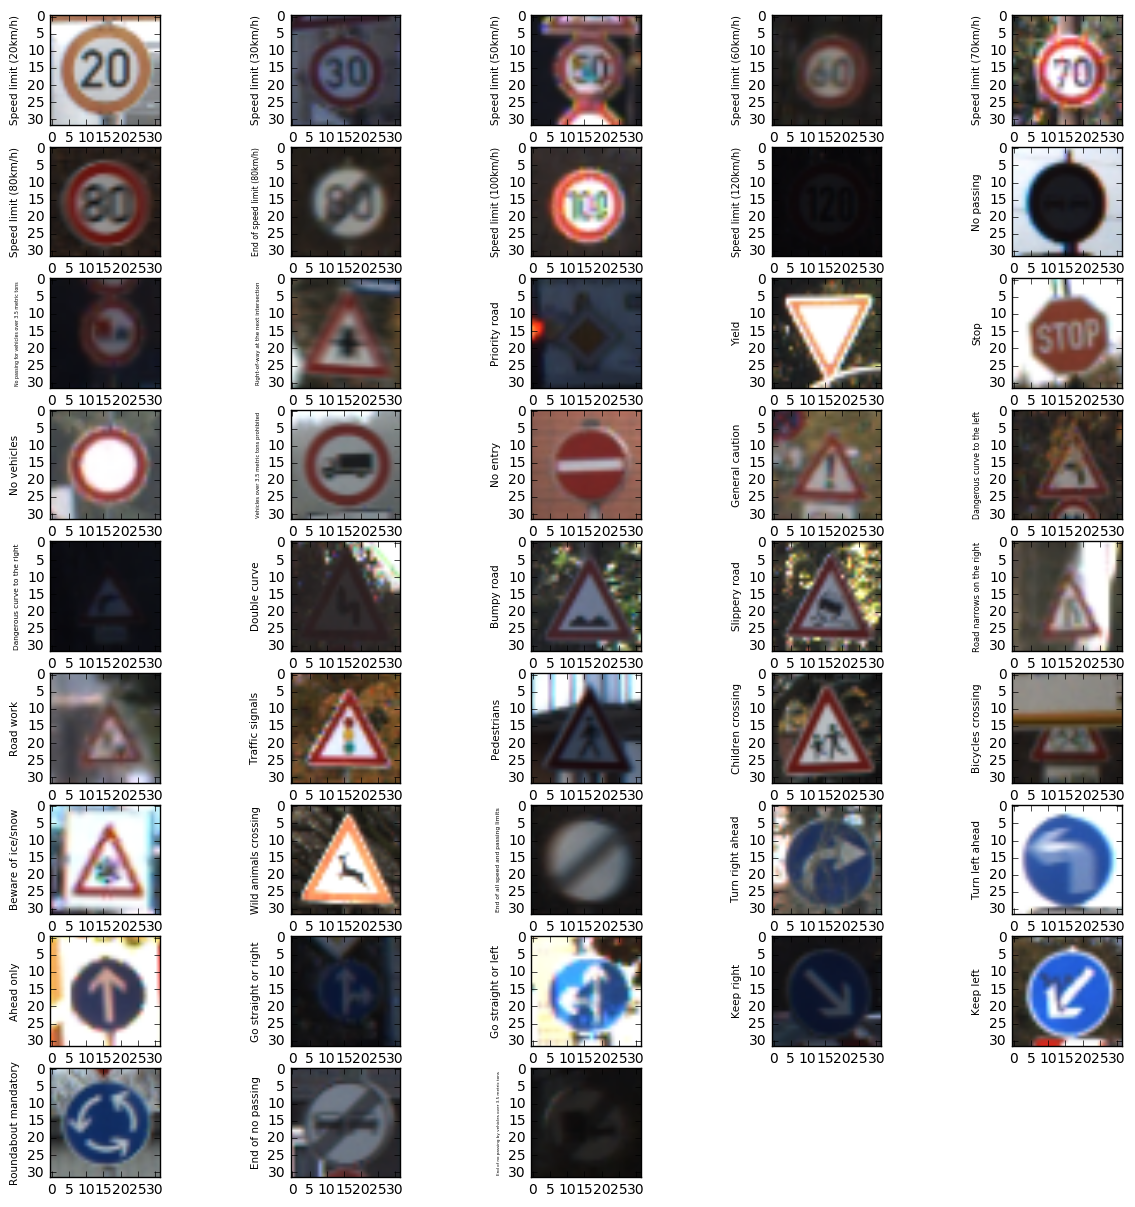

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline
print('All classes have number',eachCount,'in training data')

df = pd.read_csv('signnames.csv')

plt.figure(figsize=(15,15))
for class_idx in np.arange(n_classes):
    idx_list = np.where(y_train==class_idx)[0]
    rand_idx = idx_list[random.randint(0, len(idx_list)-1)]
    plt.subplot(9,5,class_idx+1)
    plt.imshow(X_train[rand_idx])
    plt.ylabel(df.loc[class_idx].SignName, fontsize=150/(np.max([20,len(df.loc[class_idx].SignName)])))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Normalization methods
def normalize_Yscale(image_data):
    image_data = cv2.cvtColor(image_data,cv2.COLOR_RGB2YUV)[...,0]
    image_data = image_data-np.mean(image_data)
    return image_data/np.max(np.abs(image_data))

def normalize_Uscale(image_data):
    image_data = cv2.cvtColor(image_data,cv2.COLOR_RGB2YUV)[...,1]
    image_data = image_data-np.mean(image_data)
    return image_data/np.max(np.abs(image_data))


In [5]:
out_channel = 2
X_trainN = np.zeros((n_train,X_train[0].shape[0],X_train[0].shape[1],out_channel),dtype=np.float32)
X_testN = np.zeros((n_test,X_train[0].shape[0],X_train[0].shape[1],out_channel),dtype=np.float32)

for imgIdx in range(n_train):
    X_trainN[imgIdx,:,:,0] = normalize_Yscale(X_train[imgIdx])
    X_trainN[imgIdx,:,:,1] = normalize_Uscale(X_train[imgIdx])
X_train = X_trainN

for imgIdx in range(n_test):
    X_testN[imgIdx,:,:,0] = normalize_Yscale(X_test[imgIdx])
    X_testN[imgIdx,:,:,1] = normalize_Uscale(X_test[imgIdx])
X_test = X_testN

print('X_train is of shape',X_train.shape)
print('X_test is of shape',X_test.shape)

X_train is of shape (39209, 32, 32, 2)
X_test is of shape (12630, 32, 32, 2)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I subtracted the mean, then divided by the maximum of abs values in the image (histogram equalization has the similar results)
I tried feed the raw gray values into the CNN, but it failed since the accuracy is ultimately low. Maybe it is because the scale of the data is [0, 255] and hence the 0.001 learning rate becomes improper. I also tried gaussian normalization which normalized gray values to mean=0, and var=1. It fails too.

In [6]:
### Data generation and splitting methods
def rotate_image(mat):
    ratio_rotate = 0.5
    count =0
    height, width = mat.shape[1:3]
    image_center = (width / 2, height / 2)
    for i in range(len(mat)):
        if random.random()<ratio_rotate:
            count += 1
            # control -5<angle<0 and 0<angle<5
            angle = random.random()*5
            if (random.random()-0.5)<0:
                angle *= -1
            rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.2)
            mat[i] = cv2.warpAffine(mat[i], rotation_mat, (32, 32))
    print('Rotated Num =',count)
    return mat

def splitToTrainValidation(X,y):
    validation_ratio=0.2
    class_label = np.unique(y)
    X_validation = []
    y_validation = []
    X_train = []
    y_train = []
    for classIdx in range(len(class_label)):
        idxList = np.where(y==classIdx)[0]
        sepIdx = int(np.floor(validation_ratio*len(idxList)))
        idxValidation = idxList[:sepIdx]
        idxTrain = idxList[sepIdx:]
        X_validation.extend(X[idxValidation])
        X_train.extend(X[idxTrain])
        y_validation.extend(y[idxValidation])
        y_train.extend(y[idxTrain])
    X_validation = np.array(X_validation)
    X_train = np.array(X_train)
    y_validation = np.array(y_validation)
    y_train = np.array(y_train)
    return (X_train,y_train,X_validation,y_validation)

X_validation has shape (7841, 32, 32, 2)
Before augmented dataset X_train has shape (31368, 32, 32, 2)
maxNum = 1800
Rotated Num = 38799
Final augmented dataset X_train has shape (77400, 32, 32, 2)


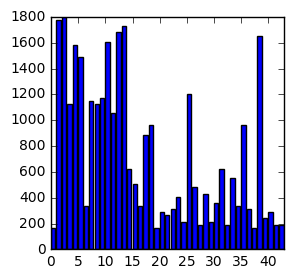

In [7]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
X_train,y_train,X_validation,y_validation = splitToTrainValidation(X_train,y_train)
print('X_validation has shape',X_validation.shape)
print('Before augmented dataset X_train has shape',X_train.shape)

# makes the number of training data for each class the same
_, count = np.unique(y_train,return_counts=True)
plt.figure(figsize=(3,3))
plt.bar(range(len(class_labels)),count)
plt.axis('tight')
maxNum = np.max(count)
print('maxNum =',maxNum)
numNeeded = maxNum-count
addImg = list()
addy = list()
for class_idx in range(len(class_labels)):
    idx_list = np.where(y_train==class_idx)[0]
    idx_list = np.tile(idx_list,int(np.ceil(maxNum/len(idx_list))))
    selected_idx = random.sample(list(idx_list), numNeeded[class_idx])
    # let the half of the data been rotated
    addImg.extend(X_train[selected_idx])
    addy.extend(y_train[selected_idx])
addImg = np.reshape(addImg,(-1,32,32,out_channel))

X_train = np.concatenate((X_train,addImg),axis=0)
X_train = rotate_image(X_train)
y_train = np.concatenate((y_train,addy),axis=0)
print('Final augmented dataset X_train has shape',X_train.shape)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
First of all, the number of each classes is inbalanced, see figure above.
So I makes them becomes equally the same number by adding images that are rotated in a small degree (-5&lt;rotation&lt;5)

The paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" indicated that
>Mixing all images at random
and subsequently separating into training and validation will
result in very similar sets, and will not accurately predict
performance on the unseen test set

Hence, for each class, I set the first 20% of **original training images** into validation set, and leave the rest of 80% as training set.
The test set should not do anything, since it is unseen in real cases.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Hyper-parameters
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.001
drop_out_keep_prob = 0.8
l2_weight = 0.01

layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'fully_connected_1': 120,
    'fully_connected_2': 84,
    'out': n_classes,
}

In [9]:
cNum = X_train.shape[-1]
mu = 0
sigma = 0.1
print('Channel Num =',cNum)
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(shape=(5, 5, cNum, layer_depth['layer_1']), mean = mu, stddev = sigma)),
    'layer_2': tf.Variable(tf.truncated_normal(shape=(5, 5, layer_depth['layer_1'], layer_depth['layer_2']), mean = mu, stddev = sigma)),
    'fully_connected_1': tf.Variable(tf.truncated_normal(shape=(5*5*layer_depth['layer_2'], layer_depth['fully_connected_1']), mean = mu, stddev = sigma)),
    'fully_connected_2': tf.Variable(tf.truncated_normal(shape=(layer_depth['fully_connected_1'], layer_depth['fully_connected_2']), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(layer_depth['fully_connected_2'], layer_depth['out']), mean = mu, stddev = sigma))
}
#+0.3 over the first epochs than +-0

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'out': tf.Variable(tf.zeros(layer_depth['out']))
}

keep_prob = tf.placeholder(tf.float32) # probability to keep units

Channel Num = 2


In [10]:
# CNN architecture
def LeNet(x):    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32xcNum. Output = 28x28xlayer_depth['layer_1'].
    conv1   = tf.nn.conv2d(x, weights['layer_1'], strides=[1, 1, 1, 1], padding='VALID') + biases['layer_1']

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28xlayer_depth['layer_1']. Output = 14x14xlayer_depth['layer_1'].
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10xlayer_depth['layer_2'].
    conv2   = tf.nn.conv2d(conv1, weights['layer_2'], strides=[1, 1, 1, 1], padding='VALID') + biases['layer_2']
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10xlayer_depth['layer_2']. Output = 5x5xlayer_depth['layer_2'].
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5xlayer_depth['layer_2']. Output = 5x5xlayer_depth['layer_2'].
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 5x5xlayer_depth['layer_2']. Output = layer_depth['fully_connected_1'].
    fc1   = tf.matmul(fc0, weights['fully_connected_1']) + biases['fully_connected_1']
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)    # dropout

    # SOLUTION: Layer 4: Fully Connected. Input = layer_depth['fully_connected_1']. Output = layer_depth['fully_connected_2'].
    fc2    = tf.matmul(fc1, weights['fully_connected_2']) + biases['fully_connected_2']
    fc2 = tf.nn.dropout(fc2, keep_prob)    # dropout
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = layer_depth['fully_connected_2']. Output = layer_depth['out'].
    logits = tf.matmul(fc2, weights['out']) + biases['out']
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I followed the traditional LeNet architecture, but add dropout to the last two fully connected layers to prevent from overfitting.
```
layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'fully_connected_1': 120,
    'fully_connected_2': 84,
    'out': n_classes,
}
```
Also, I applied ReLu as activation function.

In [11]:
# Define input/output tensors
# using one-hot decoding
x = tf.placeholder(tf.float32, (None, 32, 32, cNum))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [12]:
# Define loss, optimizer
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) +\
    l2_weight*(tf.nn.l2_loss(weights['layer_1'])+tf.nn.l2_loss(weights['layer_2'])+
          tf.nn.l2_loss(weights['fully_connected_1'])+tf.nn.l2_loss(weights['fully_connected_2'])+tf.nn.l2_loss(weights['out'])+
          tf.nn.l2_loss(biases['layer_1'])+tf.nn.l2_loss(biases['layer_2'])+
          tf.nn.l2_loss(biases['fully_connected_1'])+tf.nn.l2_loss(biases['fully_connected_2'])+tf.nn.l2_loss(biases['out']))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
# Define accuracy evaluation
# calculate the average accuracy by calling evaluate(X_data, y_data)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
### Train your model here.
# Do Training Session with German Traffic Signs Dataset
# mini-batch Adam training, will save model as ./cnn-traffic-sign
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    train_accuracy = np.zeros(EPOCHS)
    validation_accuracy = np.zeros(EPOCHS)
    for i in range(EPOCHS):
        acc_train_accuracy = 0
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out_keep_prob})
            acc_train_accuracy += evaluate(batch_x, batch_y)
        train_accuracy[i] = acc_train_accuracy/len(range(0, num_examples, BATCH_SIZE))
            
        validation_accuracy[i] = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}; Validation Accuracy = {:.3f}".format(train_accuracy[i],validation_accuracy[i]))
        print()
    saver.save(sess, './cnn-traffic-sign')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.693; Validation Accuracy = 0.769

EPOCH 2 ...
Train Accuracy = 0.929; Validation Accuracy = 0.826

EPOCH 3 ...
Train Accuracy = 0.953; Validation Accuracy = 0.872

EPOCH 4 ...
Train Accuracy = 0.961; Validation Accuracy = 0.883

EPOCH 5 ...
Train Accuracy = 0.966; Validation Accuracy = 0.883

EPOCH 6 ...
Train Accuracy = 0.968; Validation Accuracy = 0.892

EPOCH 7 ...
Train Accuracy = 0.971; Validation Accuracy = 0.890

EPOCH 8 ...
Train Accuracy = 0.972; Validation Accuracy = 0.880

EPOCH 9 ...
Train Accuracy = 0.973; Validation Accuracy = 0.892

EPOCH 10 ...
Train Accuracy = 0.974; Validation Accuracy = 0.891

EPOCH 11 ...
Train Accuracy = 0.974; Validation Accuracy = 0.891

EPOCH 12 ...
Train Accuracy = 0.975; Validation Accuracy = 0.909

EPOCH 13 ...
Train Accuracy = 0.976; Validation Accuracy = 0.900

EPOCH 14 ...
Train Accuracy = 0.975; Validation Accuracy = 0.881

EPOCH 15 ...
Train Accuracy = 0.975; Validation Accuracy = 0.891

EPOCH 

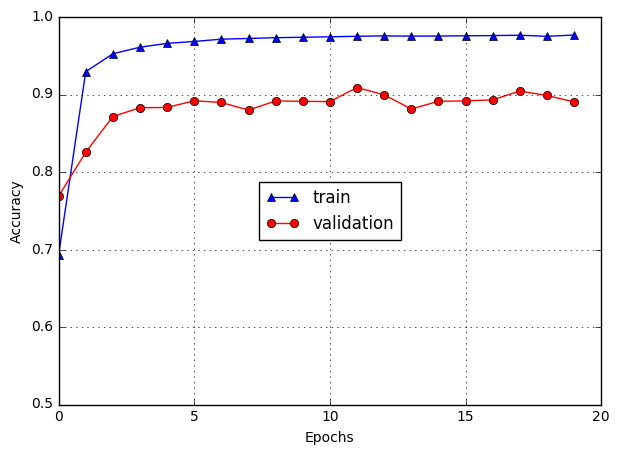

In [15]:
plt.figure(figsize=(7,5))
plt.plot(range(EPOCHS), train_accuracy, 'b-^', range(EPOCHS), validation_accuracy, 'ro-')
plt.ylim(0.5,1)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'],loc='center')
plt.grid()

In [16]:
# Calculate the test set accuracy
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.881


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

**Adam** is adopted as the optimizer. Other hyper-parameters are shown below
```
EPOCHS = 30
BATCH_SIZE = 128
rate = 0.001
drop_out_keep_prob = 0.8
l2_weight = 0.01
```

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I found that the accuracy of training is easily approaching 99%, but it usually performs bad in test set.

I think it might be overfitted. And hence, adding l2-regularization and dropout methods help leveraging this problem. However, these methods make training harder and need more epochs to converge.

I also found that adding U (Chroma) feature performs better than only has Y (Luminance) feature.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob

images = []
images_resized = []
for imgPath in glob.glob('../fromGoogleMap/*.bmp'):
    image = plt.imread(imgPath)
    image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    images_resized.append(image)
    tmp_image = np.zeros((32,32,cNum))
    tmp_image[:,:,0] = normalize_Yscale(image)
    tmp_image[:,:,1] = normalize_Uscale(image)
    images.append(tmp_image)
    
images=np.array(images)
print(images.shape)
#images=images[...,np.newaxis]
images_resized=np.array(images_resized)
print(images_resized.shape)

(20, 32, 32, 2)
(20, 32, 32, 3)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I choosed 20 images from google map. See below figures that show the images and my prediction.

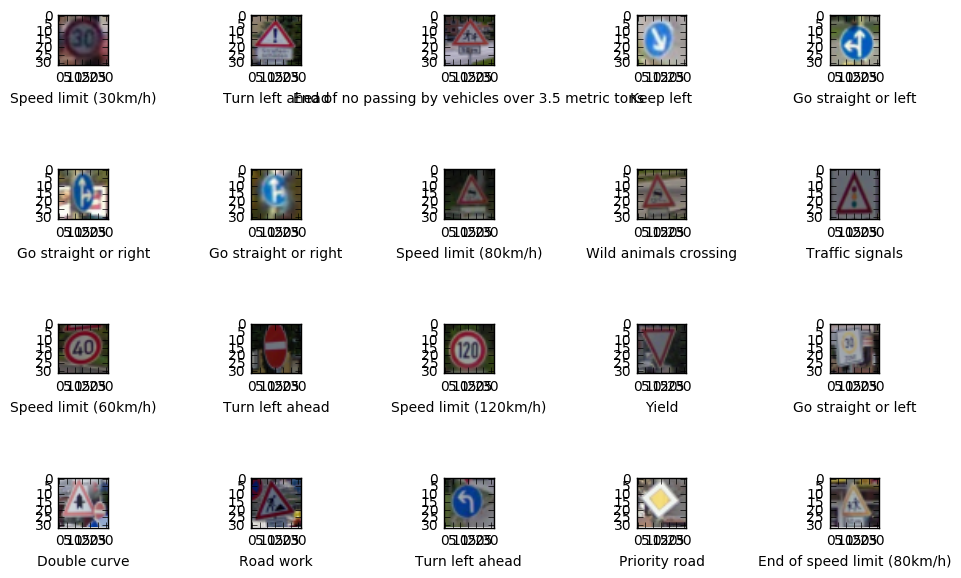

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    out = sess.run(tf.argmax(logits, 1), feed_dict={x: images, keep_prob: 1.0})

# Plot Images with prediction
plt.figure(figsize=(9,9))
for i in range(0,images_resized.shape[0]):
    plt.subplot(6, 5, i+1)
    #print(images_resized[i].shape)
    plt.imshow(images_resized[i])
    plt.xlabel(df.loc[out[i]].SignName)
plt.tight_layout()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
It predicted worse than the test set. It only has **50%** accuracy.

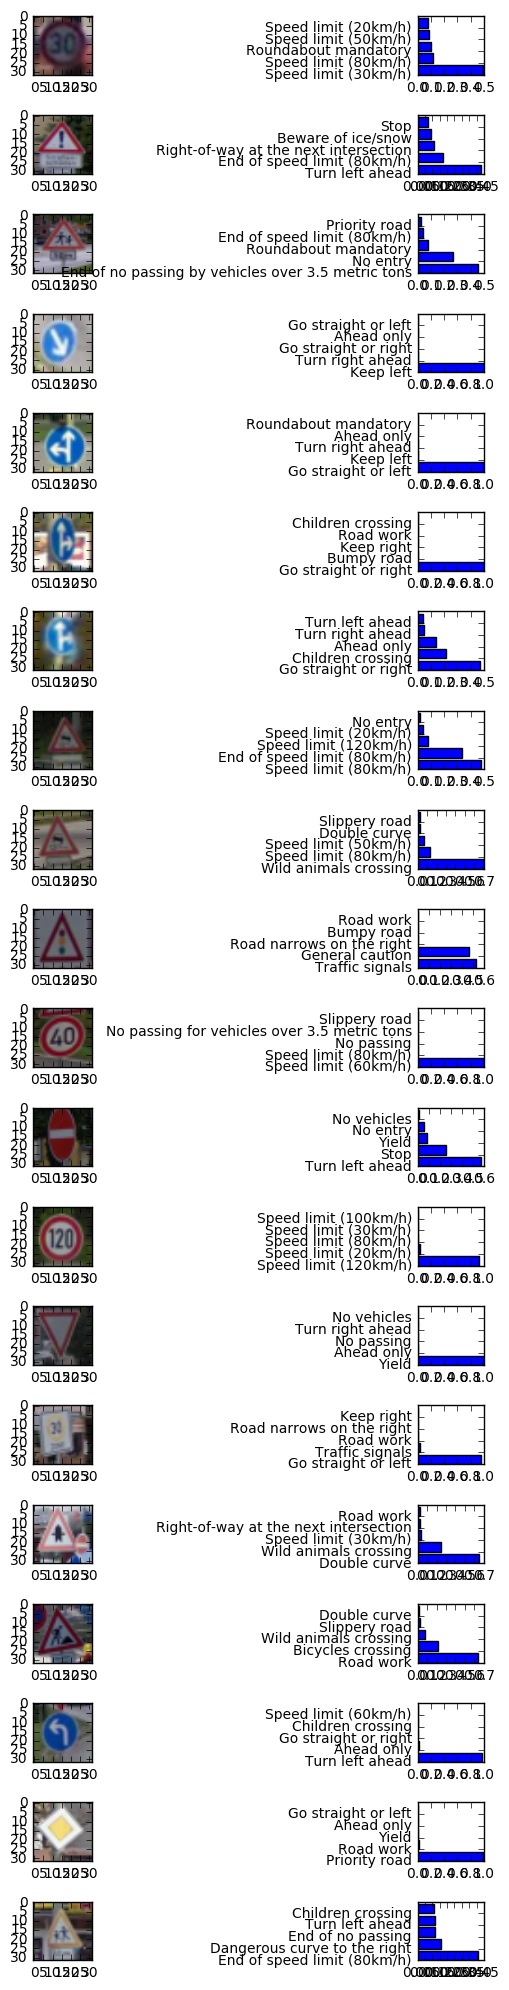

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    out = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: images, keep_prob: 1.0})
more_test_num = len(out[1])
plt.figure(figsize=(5,20))
for (i,top5_v,top5_idx) in zip(range(more_test_num),out[0],out[1]):
    plt.subplot(more_test_num,2,i*2+1)
    plt.imshow(images_resized[i])
    plt.subplot(more_test_num,2,(i+1)*2)
    sign_name = [name for name in df.loc[top5_idx].SignName]
    plt.barh(range(1,6),top5_v)
    plt.yticks(range(1,6),sign_name)
plt.tight_layout()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
By checking those error images. total has 10 error cases, where 3 of them has correct answers in top-5. Looks like the model is certain about "speed limit signs". And it is interesting that I got an error on the "Keep right" sign which has been predicted as "Keep left". Is it bacause the rotation method (to generate the fake data) confusing the training model? Seems more experiments need to be done.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.